# Correlação entre Compradores e Leads / *Correlation Between Buyers and Leads*
# Desafio de Ciência de Dados / *Data Science Challenge*
# Entrega / *Delivery*: Notebook
# Desenvolvedor / *Developer*: Solano Jacon

In [5]:
import psycopg2 # if necessary, install psycopg2-binary library, NOT psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pickle
import warnings
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

## Leitura dos dados e normalização / *Data reading and normalization*

### Conexão com a base de dados e leitura dos dados / *Database connection and data reading*

In [6]:
# conn = psycopg2.connect(database='database',
#                         host='host',
#                         user='user',
#                         password='password',
#                         port='port')

In [7]:
# sql = '''SELECT f.*, oi.id_pedido, oi.id
#          FROM forms AS f
#          LEFT OUTER JOIN order_items AS oi ON f.id_form=oi.id_form'''
# data = pd.read_sql_query(sql, con=conn)

In [8]:
data = pd.read_csv('data/data.csv', index_col=0, encoding='iso-8859-1')

In [9]:
# SELEÇÃO DE UMA AMOSTRA DOS DADOS PARA REDUÇÃO DO CONSUMO DE MEMÓRIA
# DATA SAMPLE SELECTION TO REDUCE MEMORY CONSUMPTION

data = data.sample(frac=0.5, random_state=42)

In [10]:
data.iloc[:, :9]

,id_form,id_cliente,data,sistema_operacional,navegador,localizacao,locale,cidade,estado
294324,909a67fefc16c0246d1964fd72ceee,4b12d82c9535a9b3d3f7,2022-04-01 15:14:50,Android,Chrome,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO
543790,45621dadb08be3fe2fadd50a557f85,d2e4a3d45198f076d961,2022-06-17 23:01:52,iOS,NaN,"Sao Joao de Meriti, Rio de Janeiro",BR,SAO JOAO DE MERITI,RIO DE JANEIRO
417082,82825d4e48571d1e43ccb0e9a35222,a469926e4bc08ba07015,2022-05-11 15:42:05,Android,Chrome,"Cambira, Parana",BR,CAMBIRA,PARANA
211987,d3342a020ceef4ab92760abc83c4d4,77021d6ec61149ce7ccc,2022-02-25 15:17:41,Android,Chrome,"Itanhaem, Sao Paulo",BR,ITANHAEM,SAO PAULO
186537,b238655cba8902f80a673f33016b71,983b4b8600c36e8c2f06,2022-02-15 19:35:52,iOS,NaN,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO
...,...,...,...,...,...,...,...,...,...
506355,a0c9c0bea7a35becfa3f5fabc94c9d,36f1275ede26a1773b30,2022-06-02 17:40:10,Android,Chrome,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO
480040,eda0c0539cf83f13449c94ec5085ec,55e533b13b7afb8b063d,2022-05-29 16:11:06,Android,Chrome,"Rio Real, Bahia",BR,RIO REAL,BAHIA
362897,1904025a3721fc074b444898ec1969,247f32371752b04a9793,2022-04-24 17:25:02,iOS,Safari,"São Paulo, Sao Paulo",BR,SÃO PAULO,SAO PAULO
230897,e5a44f7ecc4440d466770391509171,69a763e0553bcc259f6b,2022-03-05 19:02:45,Android,Chrome,"Sobral, Ceara",BR,SOBRAL,CEARA


In [11]:
data.iloc[:, 9:18]

,qtde_lavagem_semana,utm_source,tipo_cabelo,comprimento,tipo_fios,procedimentos,tempo_procedimento,dieta,atividade_fisica
294324,4,influencer,Tipo 2,Muito curto,Secos,"Exposição ao sol, Tintura, Corte agressivo",Há 2 semanas,Celíaca,Raramente
543790,2,facebook,Tipo 4,Raíz exposta,Pontas duplas,Exposição ao sol,Há 1 semana,Celíaca,Frequente
417082,2,influencer,Tipo 2,Raíz exposta,Secos,"Tintura, Corte agressivo",Há 2 semanas,Celíaca,N/C
211987,1,influencer,Tipo 4,Raíz exposta,Rebeldes,"Tintura, Nenhum, Corte agressivo",Há 2 semanas,Celíaca,Raramente
186537,4,facebook,Tipo 4,Raíz exposta,Secos,"Exposição ao sol, Nenhum, Tintura, Corte agres...",Há 1 semana,Nenhuma restrição,Raramente
...,...,...,...,...,...,...,...,...,...
506355,3,influencer,Tipo 2,Longo,Perfeitos,Todos acima,Há mais de 1 mês,Celíaca,Raramente
480040,1,google,Tipo 4,Raíz exposta,Pontas duplas,Tintura,Há 1 semana,Celíaca,Raramente
362897,4,google,Tipo 4,Raíz exposta,Rebeldes,Todos acima,Há mais de 1 mês,Celíaca,Raramente
230897,2,instagram,Tipo 2,Extra longo,Secos,Tintura,Há 1 semana,Leve,Frequente


In [12]:
data.iloc[:, 18:]

,frequencia_estresse,caracteristica,faixa_etaria,efeitos_desejados,fragancia,id_pedido,id
294324,Nunca,Característica 6,25 a 34,"Efeito 6, Efeito 2, Efeito 8, Efeito 1",Rosas,NaN,NaN
543790,Nunca,Característica 3,25 a 34,"Efeito 6, Efeito 4, Efeito 3, Efeito 7, Efeito 8",Eucalipto,NaN,NaN
417082,Uma vez por mês,"Característica 3, Característica 8",25 a 34,"Efeito 6, Efeito 7, Efeito 2, Efeito 4",Eucalipto,14f73eddf8b6692,546112.0
211987,Regularmente,"Característica 1, Característica 3, Caracterís...",18 a 24,"Efeito 6, Efeito 1, Efeito 3, Efeito 7",Eucalipto,NaN,NaN
186537,Regularmente,"Característica 1, Característica 10, Caracterí...",35 a 44,"Efeito 2, Efeito 10, Efeito 4, Efeito 5, Efeito 7",Eucalipto,a6fe3b735978a92,495517.0
...,...,...,...,...,...,...,...
506355,Nunca,Característica 3,25 a 34,"Efeito 2, Efeito 1, Efeito 4",Eucalipto,8a3138734d5c20b,564407.0
480040,Uma vez por mês,Característica 3,25 a 34,"Efeito 6, Efeito 8, Efeito 4",Eucalipto,NaN,NaN
362897,Nunca,Característica 8,25 a 34,"Efeito 7, Efeito 1",Eucalipto,NaN,NaN
230897,Uma vez por mês,"Característica 3, Característica 9",35 a 44,"Efeito 6, Efeito 4, Efeito 1, Efeito 3, Efeito 7",Rosas,NaN,NaN


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292736 entries, 294324 to 382088
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id_form              292736 non-null  object 
 1   id_cliente           292736 non-null  object 
 2   data                 292736 non-null  object 
 3   sistema_operacional  292736 non-null  object 
 4   navegador            226585 non-null  object 
 5   localizacao          292736 non-null  object 
 6   locale               292736 non-null  object 
 7   cidade               282930 non-null  object 
 8   estado               292616 non-null  object 
 9   qtde_lavagem_semana  292736 non-null  int64  
 10  utm_source           254729 non-null  object 
 11  tipo_cabelo          292736 non-null  object 
 12  comprimento          292736 non-null  object 
 13  tipo_fios            292736 non-null  object 
 14  procedimentos        292736 non-null  object 
 15  tempo_proced

In [14]:
data.isna().sum()

id_form                     0
id_cliente                  0
data                        0
sistema_operacional         0
navegador               66151
localizacao                 0
locale                      0
cidade                   9806
estado                    120
qtde_lavagem_semana         0
utm_source              38007
tipo_cabelo                 0
comprimento                 0
tipo_fios                   0
procedimentos               0
tempo_procedimento          0
dieta                       0
atividade_fisica            0
frequencia_estresse         0
caracteristica              0
faixa_etaria                0
efeitos_desejados         641
fragancia                   0
id_pedido              186901
id                     186901
dtype: int64

In [15]:
data = data.fillna(value=np.nan)

In [16]:
caracteres_especiais = ['\u014c', '\u014d', '\u0160', '\u0161']
caracteres_substitutos = ['O', 'o', 'S', 's']

for caractere_especial, caractere_substituto in zip(caracteres_especiais, caracteres_substitutos):
    data.loc[data['localizacao'].notna(), 'localizacao'] = data.loc[data['localizacao'].notna(), 'localizacao'].apply(lambda x: x.replace(caractere_especial, caractere_substituto))
    data.loc[data['cidade'].notna(), 'cidade'] = data.loc[data['cidade'].notna(), 'cidade'].apply(lambda x: x.replace(caractere_especial, caractere_substituto))
    data.loc[data['estado'].notna(), 'estado'] = data.loc[data['estado'].notna(), 'estado'].apply(lambda x: x.replace(caractere_especial, caractere_substituto))

In [17]:
# data.to_csv('data/data.csv', encoding='iso-8859-1')

### Análise dos Dados / *Data Analysis*

In [18]:
data['data'].min()

'2022-01-01 00:24:36'

In [19]:
data['data'].max()

'2022-06-30 23:57:47'

In [20]:
data['sistema_operacional'].value_counts(normalize=True, dropna=False)

Android      0.597128
iOS          0.331380
Windows      0.063515
Mac OS       0.005356
Linux        0.002244
 ChromeOS    0.000376
Name: sistema_operacional, dtype: float64

In [21]:
data['navegador'].value_counts(normalize=True, dropna=False)

Chrome            0.657657
NaN               0.225975
Safari            0.101351
ChromeiOS         0.006562
ChromiumEdge      0.004137
Firefox           0.002910
Opera             0.001387
MSEdge            0.000017
Yandex.Browser    0.000003
Name: navegador, dtype: float64

In [22]:
data['localizacao'].value_counts(normalize=True, dropna=False)

São Paulo, Sao Paulo                  0.128030
Rio de Janeiro, Rio de Janeiro        0.045290
Belo Horizonte, Minas Gerais          0.025122
null, null                            0.023841
Brasília, Federal District            0.023639
                                        ...   
Cachoeira do Brumado, Minas Gerais    0.000003
Mariapolis, Sao Paulo                 0.000003
Arandu, Sao Paulo                     0.000003
Tokyo, Tokyo                          0.000003
Regensdorf, Zurich                    0.000003
Name: localizacao, Length: 4978, dtype: float64

In [23]:
data['locale'].value_counts(normalize=True, dropna=False)

BR    1.0
Name: locale, dtype: float64

In [24]:
data['cidade'].value_counts(normalize=True, dropna=False)

SÃO PAULO               0.128030
RIO DE JANEIRO          0.045290
NaN                     0.033498
BELO HORIZONTE          0.025146
BRASÍLIA                0.023639
                          ...   
SAN FRANCISCO           0.000003
IGUALADA                0.000003
CACHOEIRA DO BRUMADO    0.000003
MARIAPOLIS              0.000003
REGENSDORF              0.000003
Name: cidade, Length: 4673, dtype: float64

In [25]:
data['estado'].value_counts(normalize=True, dropna=False)

 SAO PAULO                0.323271
 MINAS GERAIS             0.089661
 RIO DE JANEIRO           0.083925
 PARANA                   0.061807
 RIO GRANDE DO SUL        0.050762
                            ...   
 SHIGA                    0.000003
 SALTA                    0.000003
 DEPARTAMENTO DE ROCHA    0.000003
 CALABRIA                 0.000003
 JURA                     0.000003
Name: estado, Length: 263, dtype: float64

In [26]:
data['qtde_lavagem_semana'].value_counts(normalize=True, dropna=False)

4    0.321023
1    0.268098
2    0.160756
6    0.082371
5    0.079809
3    0.053577
7    0.034365
Name: qtde_lavagem_semana, dtype: float64

In [27]:
data['utm_source'].value_counts(normalize=True, dropna=False)

influencer         0.317019
facebook           0.206203
NaN                0.129834
google             0.086464
sf_wpp_camp        0.066292
linktree           0.054298
instagram          0.046831
sf_email_camp      0.036890
sf_wpp_flux        0.025023
rakuten            0.007860
IGShopping         0.007853
email_sf           0.003983
blog               0.003088
tiktok             0.002050
microinfluencer    0.001817
adwords            0.001606
site               0.001363
sf_email_flux      0.000926
meliuz             0.000174
incicacao          0.000133
salesforce         0.000130
whatsapp           0.000051
sendinblue         0.000031
sf_sms_camp        0.000017
telegram           0.000014
sf_wpp_flu         0.000010
facebook           0.000007
cpc                0.000007
uaubox             0.000007
sms                0.000007
teste_source       0.000003
santander          0.000003
sf_                0.000003
Facebook ads       0.000003
Name: utm_source, dtype: float64

In [28]:
data['tipo_cabelo'].value_counts(normalize=True, dropna=False)

Tipo 1    0.422237
Tipo 2    0.363618
Tipo 4    0.173689
Tipo 3    0.040456
Name: tipo_cabelo, dtype: float64

In [29]:
data['comprimento'].value_counts(normalize=True, dropna=False)

Muito curto     0.473129
Raíz exposta    0.355935
Longo           0.124067
Extra longo     0.046868
Name: comprimento, dtype: float64

In [30]:
data['tipo_fios'].value_counts(normalize=True, dropna=False)

Secos            0.571385
Pontas duplas    0.169098
Rebeldes         0.167438
Perfeitos        0.092080
Name: tipo_fios, dtype: float64

In [31]:
data['procedimentos'].value_counts(normalize=True, dropna=False)

Corte agressivo                                       0.183052
Todos acima                                           0.153476
Tintura                                               0.086337
Exposição ao sol                                      0.080298
Tintura, Corte agressivo                              0.077391
                                                        ...   
Corte agressivo, Exposição ao sol, Tintura, Nenhum    0.000304
Exposição ao sol, Tintura, Nenhum                     0.000284
Exposição ao sol, Corte agressivo, Nenhum, Tintura    0.000266
Exposição ao sol, Tintura, Nenhum, Corte agressivo    0.000184
N/C                                                   0.000003
Name: procedimentos, Length: 66, dtype: float64

In [32]:
data['tempo_procedimento'].value_counts(normalize=True, dropna=False)

Há 2 semanas               0.331613
Há 1 semana                0.273243
Há mais de 1 mês           0.185491
Há 1 mês                   0.116730
Não houve procedimentos    0.092923
Name: tempo_procedimento, dtype: float64

In [33]:
data['dieta'].value_counts(normalize=True, dropna=False)

Celíaca                  0.720321
Nenhuma restrição        0.217852
Intolerante a lactose    0.044088
Leve                     0.017740
Name: dieta, dtype: float64

In [34]:
data['atividade_fisica'].value_counts(normalize=True, dropna=False)

Raramente    0.525620
Frequente    0.282548
Sempre       0.094341
N/C          0.084253
Nunca        0.013237
Name: atividade_fisica, dtype: float64

In [35]:
data['frequencia_estresse'].value_counts(normalize=True, dropna=False)

Uma vez por mês    0.523936
Nunca              0.410858
Regularmente       0.060447
Quase sempre       0.004759
Name: frequencia_estresse, dtype: float64

In [36]:
data['caracteristica'].value_counts(normalize=True, dropna=False)

Característica 3                                                                             0.267808
Característica 7                                                                             0.103124
Característica 1                                                                             0.093730
Característica 3, Característica 8                                                           0.085388
Característica 2                                                                             0.040268
                                                                                               ...   
Característica 1, Característica 8, Característica 4, Característica 10                      0.000003
Característica 1, Característica 10, Característica 6                                        0.000003
Característica 3, Característica 10, Característica 4, Característica 6, Característica 1    0.000003
Característica 1, Característica 8, Característica 2, Característica 10           

In [37]:
data['faixa_etaria'].value_counts(normalize=True, dropna=False)

25 a 34    0.368376
18 a 24    0.270530
35 a 44    0.190568
45 a 54    0.068420
11 a 17    0.067645
55 a 64    0.021340
2 a 10     0.007372
65+        0.005749
Name: faixa_etaria, dtype: float64

In [38]:
data['efeitos_desejados'].value_counts(normalize=True, dropna=False)

Efeito 6, Efeito 7, Efeito 4, Efeito 3               0.014850
Efeito 6, Efeito 7, Efeito 8, Efeito 4, Efeito 3     0.014716
Efeito 6, Efeito 7, Efeito 8, Efeito 4               0.012199
Efeito 7                                             0.010877
Efeito 6, Efeito 2, Efeito 4, Efeito 3               0.009599
                                                       ...   
Efeito 1, Efeito 7, Efeito 5, Efeito 4, Efeito 8     0.000003
Efeito 5, Efeito 6, Efeito 8, Efeito 4, Efeito 3     0.000003
Efeito 2, Efeito 3, Efeito 10, Efeito 6, Efeito 7    0.000003
Efeito 2, Efeito 6, Efeito 1, Efeito 4, Efeito 8     0.000003
Efeito 2, Efeito 6, Efeito 10, Efeito 5, Efeito 4    0.000003
Name: efeitos_desejados, Length: 10056, dtype: float64

In [39]:
data['fragancia'].value_counts(normalize=True, dropna=False)

Rosas              0.522672
Eucalipto          0.380397
Flores do campo    0.096930
Name: fragancia, dtype: float64

### Preparação e Análise dos Dados Alvo / *Target Data Preparation and Analysis*

In [40]:
data['pedido'] = 0
data.loc[data['id_pedido'].notna(), 'pedido'] = 1

In [41]:
data['pedido'].value_counts(normalize=True, dropna=False)

0    0.638463
1    0.361537
Name: pedido, dtype: float64

### Definição dos Próximos Passos / *Definition of Next Steps*

Criação de features:
- tempo_procedimento: transformação do conteúdo de categorias ordinais de texto para categorias ordinais numéricas
- faixa_etaria: transformação do conteúdo de categorias ordinais de texto para categorias ordinais numéricas
- procedimentos: separação do conteúdo de categorias em colunas binárias para cada categoria
- caracteristica: separação do conteúdo de categorias em colunas binárias para cada categoria
- efeitos_desejados: separação do conteúdo de categorias em colunas binárias para cada categoria

*Feature creation*:
- *tempo_procedimento: transforming content from ordinal text categories to numeric ordinal categories*
- *faixa_etaria: transforming content from ordinal text categories to numeric ordinal categories*
- *procedimentos: separation of categories content into binary columns for each category*
- *caracteristica: separation of categories content into binary columns for each category*
- *efeitos_desejados: separation of categories content into binary columns for each category*

Encoding:
- sistema_operacional
- estado
- utm_source
- tipo_cabelo
- comprimento
- tipo_fios
- dieta
- atividade_fisica
- frequencia_estresse

Scaling:
- qtde_lavagem_semana

### Criação de Features / *Feature Creation*

**tempo_procedimento**

In [42]:
data['tempo_procedimento'].value_counts(normalize=True, dropna=False)

Há 2 semanas               0.331613
Há 1 semana                0.273243
Há mais de 1 mês           0.185491
Há 1 mês                   0.116730
Não houve procedimentos    0.092923
Name: tempo_procedimento, dtype: float64

In [43]:
data.loc[data['tempo_procedimento']=='Não houve procedimentos', 'tempo_procedimento_quantificado'] = 0
data.loc[data['tempo_procedimento']=='Há 1 semana', 'tempo_procedimento_quantificado'] = 1
data.loc[data['tempo_procedimento']=='Há 2 semanas', 'tempo_procedimento_quantificado'] = 2
data.loc[data['tempo_procedimento']=='Há 1 mês', 'tempo_procedimento_quantificado'] = 3
data.loc[data['tempo_procedimento']=='Há mais de 1 mês', 'tempo_procedimento_quantificado'] = 4

In [44]:
data['tempo_procedimento_quantificado'].value_counts(normalize=True, dropna=False)

2.0    0.331613
1.0    0.273243
4.0    0.185491
3.0    0.116730
0.0    0.092923
Name: tempo_procedimento_quantificado, dtype: float64

**faixa_etaria**

In [45]:
data['faixa_etaria'].value_counts(normalize=True, dropna=False)

25 a 34    0.368376
18 a 24    0.270530
35 a 44    0.190568
45 a 54    0.068420
11 a 17    0.067645
55 a 64    0.021340
2 a 10     0.007372
65+        0.005749
Name: faixa_etaria, dtype: float64

In [46]:
data.loc[data['faixa_etaria']=='2 a 10', 'faixa_etaria_quantificado'] = 1
data.loc[data['faixa_etaria']=='11 a 17', 'faixa_etaria_quantificado'] = 2
data.loc[data['faixa_etaria']=='18 a 24', 'faixa_etaria_quantificado'] = 3
data.loc[data['faixa_etaria']=='25 a 34', 'faixa_etaria_quantificado'] = 4
data.loc[data['faixa_etaria']=='35 a 44', 'faixa_etaria_quantificado'] = 5
data.loc[data['faixa_etaria']=='45 a 54', 'faixa_etaria_quantificado'] = 6
data.loc[data['faixa_etaria']=='55 a 64', 'faixa_etaria_quantificado'] = 7
data.loc[data['faixa_etaria']=='65+', 'faixa_etaria_quantificado'] = 8

In [47]:
data['faixa_etaria_quantificado'].value_counts(normalize=True, dropna=False)

4.0    0.368376
3.0    0.270530
5.0    0.190568
6.0    0.068420
2.0    0.067645
7.0    0.021340
1.0    0.007372
8.0    0.005749
Name: faixa_etaria_quantificado, dtype: float64

**procedimentos**

In [48]:
data['procedimentos'].value_counts(normalize=True, dropna=False)

Corte agressivo                                       0.183052
Todos acima                                           0.153476
Tintura                                               0.086337
Exposição ao sol                                      0.080298
Tintura, Corte agressivo                              0.077391
                                                        ...   
Corte agressivo, Exposição ao sol, Tintura, Nenhum    0.000304
Exposição ao sol, Tintura, Nenhum                     0.000284
Exposição ao sol, Corte agressivo, Nenhum, Tintura    0.000266
Exposição ao sol, Tintura, Nenhum, Corte agressivo    0.000184
N/C                                                   0.000003
Name: procedimentos, Length: 66, dtype: float64

In [49]:
procedimentos = ['Corte agressivo', 'Exposição ao sol', 'Nenhum', 'N/C', 'Tintura', 'Todos acima']

for procedimento in procedimentos:
    data['procedimento ' + procedimento] = data['procedimentos'].apply(lambda x: 1 if procedimento in x else 0)

In [50]:
data['procedimentos']

294324           Exposição ao sol, Tintura, Corte agressivo
543790                                     Exposição ao sol
417082                             Tintura, Corte agressivo
211987                     Tintura, Nenhum, Corte agressivo
186537    Exposição ao sol, Nenhum, Tintura, Corte agres...
                                ...                        
506355                                          Todos acima
480040                                              Tintura
362897                                          Todos acima
230897                                              Tintura
382088    Tintura, Corte agressivo, Nenhum, Exposição ao...
Name: procedimentos, Length: 292736, dtype: object

In [51]:
data.iloc[:, -6:]

,procedimento Corte agressivo,procedimento Exposição ao sol,procedimento Nenhum,procedimento N/C,procedimento Tintura,procedimento Todos acima
294324,1,1,0,0,1,0
543790,0,1,0,0,0,0
417082,1,0,0,0,1,0
211987,1,0,1,0,1,0
186537,1,1,1,0,1,0
...,...,...,...,...,...,...
506355,0,0,0,0,0,1
480040,0,0,0,0,1,0
362897,0,0,0,0,0,1
230897,0,0,0,0,1,0


**caracteristica**

In [52]:
data['caracteristica'].value_counts(normalize=True, dropna=False)

Característica 3                                                                             0.267808
Característica 7                                                                             0.103124
Característica 1                                                                             0.093730
Característica 3, Característica 8                                                           0.085388
Característica 2                                                                             0.040268
                                                                                               ...   
Característica 1, Característica 8, Característica 4, Característica 10                      0.000003
Característica 1, Característica 10, Característica 6                                        0.000003
Característica 3, Característica 10, Característica 4, Característica 6, Característica 1    0.000003
Característica 1, Característica 8, Característica 2, Característica 10           

In [53]:
# A coluna caracteristica contém 10 categorias de 1 a 10 no formato "Característica 5"
# The column caracteristica contains 10 categories from 1 to 10 in the "Característica 5" format

for numero_caracteristica in range(1, 11):
    data['caracteristica ' + str(numero_caracteristica)] = data['caracteristica'].apply(lambda x: 1 if ('Característica ' + str(numero_caracteristica)) in x else 0)

In [54]:
data['caracteristica']

294324                                     Característica 6
543790                                     Característica 3
417082                   Característica 3, Característica 8
211987    Característica 1, Característica 3, Caracterís...
186537    Característica 1, Característica 10, Caracterí...
                                ...                        
506355                                     Característica 3
480040                                     Característica 3
362897                                     Característica 8
230897                   Característica 3, Característica 9
382088                                     Característica 2
Name: caracteristica, Length: 292736, dtype: object

In [55]:
data.iloc[:, -10:]

,caracteristica 1,caracteristica 2,caracteristica 3,caracteristica 4,caracteristica 5,caracteristica 6,caracteristica 7,caracteristica 8,caracteristica 9,caracteristica 10
294324,0,0,0,0,0,1,0,0,0,0
543790,0,0,1,0,0,0,0,0,0,0
417082,0,0,1,0,0,0,0,1,0,0
211987,1,0,1,0,0,0,0,1,0,1
186537,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
506355,0,0,1,0,0,0,0,0,0,0
480040,0,0,1,0,0,0,0,0,0,0
362897,0,0,0,0,0,0,0,1,0,0
230897,0,0,1,0,0,0,0,0,1,0


**efeitos_desejados**

In [56]:
data['efeitos_desejados'].value_counts(normalize=True, dropna=False)

Efeito 6, Efeito 7, Efeito 4, Efeito 3               0.014850
Efeito 6, Efeito 7, Efeito 8, Efeito 4, Efeito 3     0.014716
Efeito 6, Efeito 7, Efeito 8, Efeito 4               0.012199
Efeito 7                                             0.010877
Efeito 6, Efeito 2, Efeito 4, Efeito 3               0.009599
                                                       ...   
Efeito 1, Efeito 7, Efeito 5, Efeito 4, Efeito 8     0.000003
Efeito 5, Efeito 6, Efeito 8, Efeito 4, Efeito 3     0.000003
Efeito 2, Efeito 3, Efeito 10, Efeito 6, Efeito 7    0.000003
Efeito 2, Efeito 6, Efeito 1, Efeito 4, Efeito 8     0.000003
Efeito 2, Efeito 6, Efeito 10, Efeito 5, Efeito 4    0.000003
Name: efeitos_desejados, Length: 10056, dtype: float64

In [57]:
# A coluna efeitos_desejados contém 10 categorias de 1 a 10 no formato "Efeito 5"
# The column efeitos_desejados contains 10 categories from 1 to 10 in the "Efeito 5" format

data['efeitos_desejados_modificado'] = data['efeitos_desejados'].fillna(value='Nenhum')

for numero_efeito in range(1, 11):
    data['efeitos_desejados ' + str(numero_efeito)] = data['efeitos_desejados_modificado'].apply(lambda x: 1 if ('Efeito ' + str(numero_efeito)) in x else 0)

In [58]:
data['efeitos_desejados']

294324               Efeito 6, Efeito 2, Efeito 8, Efeito 1
543790     Efeito 6, Efeito 4, Efeito 3, Efeito 7, Efeito 8
417082               Efeito 6, Efeito 7, Efeito 2, Efeito 4
211987               Efeito 6, Efeito 1, Efeito 3, Efeito 7
186537    Efeito 2, Efeito 10, Efeito 4, Efeito 5, Efeito 7
                                ...                        
506355                         Efeito 2, Efeito 1, Efeito 4
480040                         Efeito 6, Efeito 8, Efeito 4
362897                                   Efeito 7, Efeito 1
230897     Efeito 6, Efeito 4, Efeito 1, Efeito 3, Efeito 7
382088                                   Efeito 6, Efeito 7
Name: efeitos_desejados, Length: 292736, dtype: object

In [59]:
data.iloc[:, -10:]

,efeitos_desejados 1,efeitos_desejados 2,efeitos_desejados 3,efeitos_desejados 4,efeitos_desejados 5,efeitos_desejados 6,efeitos_desejados 7,efeitos_desejados 8,efeitos_desejados 9,efeitos_desejados 10
294324,1,1,0,0,0,1,0,1,0,0
543790,0,0,1,1,0,1,1,1,0,0
417082,0,1,0,1,0,1,1,0,0,0
211987,1,0,1,0,0,1,1,0,0,0
186537,1,1,0,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
506355,1,1,0,1,0,0,0,0,0,0
480040,0,0,0,1,0,1,0,1,0,0
362897,1,0,0,0,0,0,1,0,0,0
230897,1,0,1,1,0,1,1,0,0,0


### Encoding

**sistema_operacional**

In [60]:
data['sistema_operacional'].unique()

array(['Android', 'iOS', 'Mac OS', 'Windows', 'Linux', ' ChromeOS'],
      dtype=object)

In [61]:
feature_to_encode = 'sistema_operacional'
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(data[[feature_to_encode]])
data[feature_to_encode + '_e_' + ohe.categories_[0]] = column_encoded

In [62]:
ohe.categories_

[array([' ChromeOS', 'Android', 'Linux', 'Mac OS', 'Windows', 'iOS'],
       dtype=object)]

In [63]:
data.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       'utm_source', 'tipo_cabelo', 'comprimento', 'tipo_fios',
       'procedimentos', 'tempo_procedimento', 'dieta', 'atividade_fisica',
       'frequencia_estresse', 'caracteristica', 'faixa_etaria',
       'efeitos_desejados', 'fragancia', 'id_pedido', 'id', 'pedido',
       'tempo_procedimento_quantificado', 'faixa_etaria_quantificado',
       'procedimento Corte agressivo', 'procedimento Exposição ao sol',
       'procedimento Nenhum', 'procedimento N/C', 'procedimento Tintura',
       'procedimento Todos acima', 'caracteristica 1', 'caracteristica 2',
       'caracteristica 3', 'caracteristica 4', 'caracteristica 5',
       'caracteristica 6', 'caracteristica 7', 'caracteristica 8',
       'caracteristica 9', 'caracteristica 10', 'efeitos_desejados_modificado',
       'efeitos_desejados 1', 'efeitos_desejados 2', 'efeitos_desejado

**estado**

In [64]:
data['estado'].unique()

array([' SAO PAULO', ' RIO DE JANEIRO', ' PARANA', ' FEDERAL DISTRICT',
       ' ALAGOAS', ' PARA', ' MINAS GERAIS', ' GOIAS',
       ' RIO GRANDE DO SUL', ' MATO GROSSO', ' BAHIA', ' CEARA',
       ' MATO GROSSO DO SUL', ' ESPIRITO SANTO', ' SANTA CATARINA',
       ' AMAZONAS', ' PARAÍBA', ' RIO GRANDE DO NORTE', ' MARANHAO',
       ' PERNAMBUCO', ' TOCANTINS', ' RONDONIA', ' SERGIPE', ' NULL',
       ' RORAIMA', ' PIAUI', ' ENGLAND', ' CASTILLE AND LEÓN', ' FLORIDA',
       ' MEXICO CITY', ' ACRE', ' AMAPA', ' DISTRICT OF COLUMBIA',
       ' MASSACHUSETTS', ' CORDOBA', ' BADEN-WÜRTTEMBERG', nan,
       ' EMILIA-ROMAGNA', ' LISBON', ' MADRID', ' OHIO', ' HAMBURG',
       ' PIEDMONT', ' FARO', ' BRITISH COLUMBIA',
       ' DEPARTAMENTO DEL ALTO PARANA', ' NEW JERSEY', ' GENEVA',
       ' LOMBARDY', ' SANTARÉM', ' DEPARTAMENTO DE LA PAZ',
       ' DEPARTAMENTO DE ROCHA', ' CALIFORNIA', ' PORTO', ' MADEIRA',
       ' BUENOS AIRES', ' AUVERGNE-RHONE-ALPES', ' ÎLE-DE-FRANCE',
       ' ASUN

In [65]:
data['estado_modificado'] = data['estado'].fillna(value='SEM PREENCHIMENTO')

In [66]:
feature_to_encode = 'estado_modificado'
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(data[[feature_to_encode]])
data[feature_to_encode + '_e_' + ohe.categories_[0]] = column_encoded

In [67]:
ohe.categories_[0]

array([' AARGAU', ' ABRUZZO', ' ABU DHABI', ' ACRE', ' AICHI',
       ' AL ASIMAH', ' ALABAMA', ' ALAGOAS', ' ALBERTA', ' AMAPA',
       ' AMAZONAS', ' ANDALUSIA', ' APULIA', ' ARAGON', ' ARIZONA',
       ' ASUNCION', ' ATLÁNTICO', ' ATTICA', ' AUVERGNE-RHONE-ALPES',
       ' AVEIRO', ' AZORES', ' BADEN-WÜRTTEMBERG', ' BAFATA', ' BAHIA',
       ' BAJA CALIFORNIA', ' BALADIYAT AD DAWHAH', ' BALEARIC ISLANDS',
       ' BARANYA', ' BASQUE COUNTRY', ' BAVARIA', ' BEJA', ' BERN',
       ' BICOL', ' BOGOTA D.C.', ' BRAGA', ' BRAGANÇA', ' BRATISLAVA',
       ' BRITISH COLUMBIA', ' BRITTANY', ' BRUSSELS CAPITAL',
       ' BUENOS AIRES', ' BUENOS AIRES F.D.', ' CALABRIA', ' CALIFORNIA',
       ' CAMPANIA', ' CANARY ISLANDS', ' CANELONES', ' CAPITAL REGION',
       ' CASTELO BRANCO', ' CASTILLE AND LEÓN', ' CASTILLE-LA MANCHA',
       ' CATALONIA', ' CEARA', ' CENTRAL JUTLAND', ' CENTRAL VISAYAS',
       ' CERRO LARGO', ' CHIHUAHUA', ' CIDADE DE MAPUTO', ' COAHUILA',
       ' COIMBRA', ' COLORAD

In [68]:
data.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'estado_modificado_e_ WALLONIA', 'estado_modificado_e_ WASHINGTON',
       'estado_modificado_e_ YUCATÁN', 'estado_modificado_e_ ZEELAND',
       'estado_modificado_e_ ZULIA', 'estado_modificado_e_ ZURICH',
       'estado_modificado_e_ ÉVORA', 'estado_modificado_e_ ÎLE-DE-FRANCE',
       'estado_modificado_e_ ÑUBLE', 'estado_modificado_e_SEM PREENCHIMENTO'],
      dtype='object', length=325)

**utm_source**

In [69]:
data['utm_source'].unique()

array(['influencer', 'facebook', 'sf_wpp_camp', 'google', nan,
       'sf_email_camp', 'rakuten', 'IGShopping', 'instagram', 'linktree',
       'sf_wpp_flux', 'salesforce', 'microinfluencer', 'email_sf',
       'tiktok', 'meliuz', 'blog', 'site', 'adwords', 'sf_email_flux',
       'incicacao', 'sf_wpp_flu', 'sendinblue', 'sf_', 'sms', 'uaubox',
       'telegram', 'whatsapp', 'sf_sms_camp', 'cpc', 'teste_source',
       'santander', 'facebook ', 'Facebook ads '], dtype=object)

In [70]:
data['utm_source_modificado'] = data['utm_source'].fillna(value='SEM PREENCHIMENTO')

In [71]:
feature_to_encode = 'utm_source_modificado'
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(data[[feature_to_encode]])
data[feature_to_encode + '_e_' + ohe.categories_[0]] = column_encoded

In [72]:
ohe.categories_

[array(['Facebook ads ', 'IGShopping', 'SEM PREENCHIMENTO', 'adwords',
        'blog', 'cpc', 'email_sf', 'facebook', 'facebook ', 'google',
        'incicacao', 'influencer', 'instagram', 'linktree', 'meliuz',
        'microinfluencer', 'rakuten', 'salesforce', 'santander',
        'sendinblue', 'sf_', 'sf_email_camp', 'sf_email_flux',
        'sf_sms_camp', 'sf_wpp_camp', 'sf_wpp_flu', 'sf_wpp_flux', 'site',
        'sms', 'telegram', 'teste_source', 'tiktok', 'uaubox', 'whatsapp'],
       dtype=object)]

In [73]:
data.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'utm_source_modificado_e_sf_wpp_camp',
       'utm_source_modificado_e_sf_wpp_flu',
       'utm_source_modificado_e_sf_wpp_flux', 'utm_source_modificado_e_site',
       'utm_source_modificado_e_sms', 'utm_source_modificado_e_telegram',
       'utm_source_modificado_e_teste_source',
       'utm_source_modificado_e_tiktok', 'utm_source_modificado_e_uaubox',
       'utm_source_modificado_e_whatsapp'],
      dtype='object', length=360)

**tipo_cabelo**

In [74]:
data['tipo_cabelo'].unique()

array(['Tipo 2', 'Tipo 4', 'Tipo 1', 'Tipo 3'], dtype=object)

In [75]:
feature_to_encode = 'tipo_cabelo'
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(data[[feature_to_encode]])
data[feature_to_encode + '_e_' + ohe.categories_[0]] = column_encoded

In [76]:
ohe.categories_

[array(['Tipo 1', 'Tipo 2', 'Tipo 3', 'Tipo 4'], dtype=object)]

In [77]:
data.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'utm_source_modificado_e_sms', 'utm_source_modificado_e_telegram',
       'utm_source_modificado_e_teste_source',
       'utm_source_modificado_e_tiktok', 'utm_source_modificado_e_uaubox',
       'utm_source_modificado_e_whatsapp', 'tipo_cabelo_e_Tipo 1',
       'tipo_cabelo_e_Tipo 2', 'tipo_cabelo_e_Tipo 3', 'tipo_cabelo_e_Tipo 4'],
      dtype='object', length=364)

**comprimento**

In [78]:
data['comprimento'].unique()

array(['Muito curto', 'Raíz exposta', 'Longo', 'Extra longo'],
      dtype=object)

In [79]:
feature_to_encode = 'comprimento'
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(data[[feature_to_encode]])
data[feature_to_encode + '_e_' + ohe.categories_[0]] = column_encoded

In [80]:
ohe.categories_

[array(['Extra longo', 'Longo', 'Muito curto', 'Raíz exposta'],
       dtype=object)]

In [81]:
data.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'utm_source_modificado_e_uaubox', 'utm_source_modificado_e_whatsapp',
       'tipo_cabelo_e_Tipo 1', 'tipo_cabelo_e_Tipo 2', 'tipo_cabelo_e_Tipo 3',
       'tipo_cabelo_e_Tipo 4', 'comprimento_e_Extra longo',
       'comprimento_e_Longo', 'comprimento_e_Muito curto',
       'comprimento_e_Raíz exposta'],
      dtype='object', length=368)

**tipo_fios**

In [82]:
data['tipo_fios'].unique()

array(['Secos', 'Pontas duplas', 'Rebeldes', 'Perfeitos'], dtype=object)

In [83]:
feature_to_encode = 'tipo_fios'
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(data[[feature_to_encode]])
data[feature_to_encode + '_e_' + ohe.categories_[0]] = column_encoded

In [84]:
ohe.categories_

[array(['Perfeitos', 'Pontas duplas', 'Rebeldes', 'Secos'], dtype=object)]

In [85]:
data.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'tipo_cabelo_e_Tipo 3', 'tipo_cabelo_e_Tipo 4',
       'comprimento_e_Extra longo', 'comprimento_e_Longo',
       'comprimento_e_Muito curto', 'comprimento_e_Raíz exposta',
       'tipo_fios_e_Perfeitos', 'tipo_fios_e_Pontas duplas',
       'tipo_fios_e_Rebeldes', 'tipo_fios_e_Secos'],
      dtype='object', length=372)

**dieta**

In [86]:
data['dieta'].unique()

array(['Celíaca', 'Nenhuma restrição', 'Intolerante a lactose', 'Leve'],
      dtype=object)

In [87]:
feature_to_encode = 'dieta'
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(data[[feature_to_encode]])
data[feature_to_encode + '_e_' + ohe.categories_[0]] = column_encoded

In [88]:
ohe.categories_

[array(['Celíaca', 'Intolerante a lactose', 'Leve', 'Nenhuma restrição'],
       dtype=object)]

In [89]:
data.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'comprimento_e_Muito curto', 'comprimento_e_Raíz exposta',
       'tipo_fios_e_Perfeitos', 'tipo_fios_e_Pontas duplas',
       'tipo_fios_e_Rebeldes', 'tipo_fios_e_Secos', 'dieta_e_Celíaca',
       'dieta_e_Intolerante a lactose', 'dieta_e_Leve',
       'dieta_e_Nenhuma restrição'],
      dtype='object', length=376)

**atividade_fisica**

In [90]:
data['atividade_fisica'].unique()

array(['Raramente', 'Frequente', 'N/C', 'Sempre', 'Nunca'], dtype=object)

In [91]:
feature_to_encode = 'atividade_fisica'
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(data[[feature_to_encode]])
data[feature_to_encode + '_e_' + ohe.categories_[0]] = column_encoded

In [92]:
ohe.categories_

[array(['Frequente', 'N/C', 'Nunca', 'Raramente', 'Sempre'], dtype=object)]

In [93]:
data.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'tipo_fios_e_Secos', 'dieta_e_Celíaca', 'dieta_e_Intolerante a lactose',
       'dieta_e_Leve', 'dieta_e_Nenhuma restrição',
       'atividade_fisica_e_Frequente', 'atividade_fisica_e_N/C',
       'atividade_fisica_e_Nunca', 'atividade_fisica_e_Raramente',
       'atividade_fisica_e_Sempre'],
      dtype='object', length=381)

**frequencia_estresse**

In [94]:
data['frequencia_estresse'].unique()

array(['Nunca', 'Uma vez por mês', 'Regularmente', 'Quase sempre'],
      dtype=object)

In [95]:
feature_to_encode = 'frequencia_estresse'
ohe = OneHotEncoder(sparse=False)
column_encoded = ohe.fit_transform(data[[feature_to_encode]])
data[feature_to_encode + '_e_' + ohe.categories_[0]] = column_encoded

In [96]:
ohe.categories_

[array(['Nunca', 'Quase sempre', 'Regularmente', 'Uma vez por mês'],
       dtype=object)]

In [97]:
data.columns

Index(['id_form', 'id_cliente', 'data', 'sistema_operacional', 'navegador',
       'localizacao', 'locale', 'cidade', 'estado', 'qtde_lavagem_semana',
       ...
       'dieta_e_Nenhuma restrição', 'atividade_fisica_e_Frequente',
       'atividade_fisica_e_N/C', 'atividade_fisica_e_Nunca',
       'atividade_fisica_e_Raramente', 'atividade_fisica_e_Sempre',
       'frequencia_estresse_e_Nunca', 'frequencia_estresse_e_Quase sempre',
       'frequencia_estresse_e_Regularmente',
       'frequencia_estresse_e_Uma vez por mês'],
      dtype='object', length=385)

### Scaling

**qtde_lavagem_semana**

In [98]:
feature_to_scale = 'qtde_lavagem_semana'
mms = MinMaxScaler()
mms.fit(data[[feature_to_scale]])
data[feature_to_scale + '_std'] = mms.transform(data[[feature_to_scale]])
data[[feature_to_scale, feature_to_scale + '_std']]

,qtde_lavagem_semana,qtde_lavagem_semana_std
294324,4,0.500000
543790,2,0.166667
417082,2,0.166667
211987,1,0.000000
186537,4,0.500000
...,...,...
506355,3,0.333333
480040,1,0.000000
362897,4,0.500000
230897,2,0.166667


## Separação de bases para treinar e efetuar o crossvalidation / *Separation of bases for training and crossvalidation*

### Separação de uma amostra dos dados para avaliação dos modelos / *Separation of a sample of data for evaluation of models*

In [99]:
data_sample = data.sample(frac=0.025, random_state=42)

X = data_sample.drop(columns=['id_form', 'id_cliente', 'data', 'navegador', 'localizacao', 'locale', 'cidade', 'fragancia', 'id_pedido', 'id', \
                              'tempo_procedimento', 'faixa_etaria', 'procedimentos', 'caracteristica', 'efeitos_desejados', 'efeitos_desejados_modificado', \
                              'sistema_operacional', 'estado', 'estado_modificado', 'utm_source', 'utm_source_modificado', 'tipo_cabelo', 'comprimento', 'tipo_fios', 'dieta', 'atividade_fisica', 'frequencia_estresse', \
                              'qtde_lavagem_semana', \
                              'pedido'])

y = data_sample['pedido']

del data_sample

### Análise de desempenho de vários modelos com sua configuração padrão / *Performance analysis of various models with their default configuration*

In [100]:
model = DummyClassifier(random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.63
Precision = 0.0
Recall = 0.0
F1 score = 0.0


In [101]:
model = LogisticRegression(random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.65
Precision = 0.54
Recall = 0.26
F1 score = 0.35


In [102]:
model = KNeighborsClassifier()
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.6
Precision = 0.43
Recall = 0.31
F1 score = 0.36


In [103]:
model = SGDClassifier(random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.57
Precision = 0.46
Recall = 0.54
F1 score = 0.43


In [104]:
model = SVC(random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.64
Precision = 0.58
Recall = 0.09
F1 score = 0.15


In [105]:
model = DecisionTreeClassifier(random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.57
Precision = 0.42
Recall = 0.43
F1 score = 0.42


In [106]:
model = RandomForestClassifier(random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.65
Precision = 0.56
Recall = 0.15
F1 score = 0.24


In [107]:
model = AdaBoostClassifier(random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.64
Precision = 0.53
Recall = 0.26
F1 score = 0.35


In [108]:
model = GradientBoostingClassifier(random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.65
Precision = 0.55
Recall = 0.2
F1 score = 0.29


In [109]:
model = XGBClassifier(verbosity=0, random_state=42)
cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

print('Accuracy =', round(cv_results['test_accuracy'].mean(), 2))
print('Precision =', round(cv_results['test_precision'].mean(), 2))
print('Recall =', round(cv_results['test_recall'].mean(), 2))
print('F1 score =', round(cv_results['test_f1'].mean(), 2))

Accuracy = 0.65
Precision = 0.55
Recall = 0.2
F1 score = 0.3


### Separação dos dados em dados para treino e dados para teste para avaliação do modelo escolhido / *Separation of data into training data and test data for evaluation of the chosen model*

In [110]:
X = data.drop(columns=['id_form', 'id_cliente', 'data', 'navegador', 'localizacao', 'locale', 'cidade', 'fragancia', 'id_pedido', 'id', \
                       'tempo_procedimento', 'faixa_etaria', 'procedimentos', 'caracteristica', 'efeitos_desejados', 'efeitos_desejados_modificado', \
                       'sistema_operacional', 'estado', 'estado_modificado', 'utm_source', 'utm_source_modificado', 'tipo_cabelo', 'comprimento', 'tipo_fios', 'dieta', 'atividade_fisica', 'frequencia_estresse', \
                       'qtde_lavagem_semana', \
                       'pedido'])

y = data['pedido']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Análise de desempenho do modelo escolhido com sua configuração padrão / *Performance analysis of the chosen model with its default configuration*

In [111]:
%%time

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)

print(classification_report(y_true=y_test, y_pred=y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80     55817
           1       0.65      0.79      0.71     32004

    accuracy                           0.77     87821
   macro avg       0.75      0.77      0.76     87821
weighted avg       0.78      0.77      0.77     87821

CPU times: user 8.8 s, sys: 18.8 ms, total: 8.82 s
Wall time: 8.75 s


In [112]:
confusion_matrix(y_true=y_test, y_pred=y_pred_test)

array([[41988, 13829],
       [ 6663, 25341]])

### Análise de desempenho do modelo escolhido com balanceamento de classes do dado alvo a ser predito / *Performance analysis of the chosen model with class balancing of the target data to be predicted*

In [113]:
# BLOCOS ABAIXO COMENTADOS PELA DEMORA NA EXECUÇÃO E ALTO CONSUMO DE MEMÓRIA SEM AGREGAR AUMENTO DE PERFORMANCE PARA O MODELO
# BLOCKS BELOW COMMENTATED BY THE DELAY IN EXECUTION AND HIGH MEMORY CONSUMPTION WITHOUT ADDING INCREASE IN PERFORMANCE TO THE MODEL

In [114]:
# %%time

# sm = SMOTE(random_state=42)
# X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [115]:
# %%time

# model = DecisionTreeClassifier(random_state=42)
# model.fit(X_train_smote, y_train_smote)
# y_pred_test = model.predict(X_test)
# y_pred_proba_test = model.predict_proba(X_test)

# print(classification_report(y_true=y_test, y_pred=y_pred_test))

In [116]:
# confusion_matrix(y_true=y_test, y_pred=y_pred_test)

### Otimização do modelo escolhido baseado em ajuste de hiperparâmetros / *Optimization of the chosen model based on hyperparameter tuning*

In [117]:
# BLOCOS ABAIXO COMENTADOS PELO ALTO CONSUMO DE MEMÓRIA
# BLOCKS BELOW COMMENTATED BY HIGH MEMORY CONSUMPTION

In [118]:
# %%time

# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [2, 4, 6, 8, 10, 12, None],
#     'random_state': [42]
# }

# model = DecisionTreeClassifier()
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)
# grid_search.fit(X_train, y_train)

In [119]:
# grid_search.best_params_

In [120]:
# model = grid_search.best_estimator_
model = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=42)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)

print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81     48906
           1       0.79      0.65      0.71     38915

    accuracy                           0.77     87821
   macro avg       0.77      0.76      0.76     87821
weighted avg       0.77      0.77      0.76     87821



## Respaldo teórico e prático sobre as escolhas dos algoritmos (podendo ser mais de um) / *Theoretical and practical support on the choices of algorithms (there may be more than one)*

### Definição do dado alvo a ser predito pelo modelo / *Definition of the target data to be predicted by the model*

Lead se tornará (ou não se tornará) comprador. / *Lead will become (or not become) a buyer.*

### Escolha da métrica de performance

F1-SCORE:
- Métrica que representa um balanço entre as métricas Precisão e Recall.
- A Precisão representa a quantidade de acertos do modelo em relação à quantidade total de predições.
- O Recall representa a quantidade de acertos do modelo em relação à quantidade real de elementos daquela classe.
- A escolha dessa métrica visa que o modelo identifique a maior quantidade possível de leads que se tornarão compradores, com a menor quantidade possível de alarmes falsos (leads que não se tornarão compradores identificados pelo modelo como leads que se tornarão compradores).

*F1-SCORE:*
- *Metric that represents a balance between the Precision and Recall metrics.*
- *Precision represents the number of hits of the model in relation to the total number of predictions.*
- *Recall represents the number of hits in the model in relation to the actual number of elements of that class.*
- *The choice of this metric aims for the model to identify the largest possible number of leads that will become buyers, with the least possible amount of false alarms (leads that will not become buyers identified by the model as leads that will become buyers).*

### Escolha do modelo / *model choice*

Tipos de modelo avaliados e suas respectivas performances / *Types of model evaluated and their respective performances*:
- Logistic Regression | F1 score = 0,35
- K Neighbors Classifier | F1 score = 0,36
- SGD Classifier | F1 score = 0,41
- SVC | F1 score = 0,15
- Decision Tree Classifier | F1 score = 0,42
- Random Forest Classifier | F1 score = 0,24
- AdaBoost Classifier | F1 score = 0,35
- Gradient Boosting Classifier | F1 score = 0,29
- XGBoost Classifier | F1 score = 0,30

Tipo de modelo escolhido por apresentar a melhor performance / *Type of model chosen for presenting the best performance*:
- Decision Tree Classifier

### Divisão dos dados / *data division*:

Os dados foram divididos em dados de treino e dados de teste do modelo, na proporção de 70% e 30% respectivamente / *The data were divided into training data and model test data, in the proportion of 70% and 30% respectively*.

### Técnicas aplicadas para melhoria da performance do modelo / *Techniques applied to improve the performance of the model*:

- Scaling das features.
- Balanceamento de classes do dado alvo a ser predito (avaliada mas não aplicada pois não melhorou a performance).
- Otimização de modelo baseado em ajuste de hiperparâmetros.


- *Features scaling.*
- *Class balancing of the target data to be predicted (evaluated but not applied as it did not improve performance).*
- *Model optimization based on hyperparameter tuning.*

## Como e porquê foram escolhidas as features analisadas / *How and why the analyzed features were chosen*

- Temos 3 tabelas de dados, forms, orders e order_items, porém apenas os dados da tabela forms estarão disponíveis para o modelo fazer a predição dos leads que se tornarão compradores, portanto as features precisar sair dessa tabela, e não das tabelas orders e order_items.
- Como não foi disponibilizada nenhuma documentação referente à essa tabela forms, seu conteúdo foi conhecido através da análise de seus dados.
- Foram selecionados dados dessa tabela forms que poderiam contribuir para a predição do modelo, e as features foram criadas a partir desses dados.


- *We have 3 data tables, forms, orders and order_items, but only the data from the forms table will be available for the model to predict the leads that will become buyers, so the features need to come out of this table, and not from the orders and order_items tables.*
- *As no documentation regarding this forms table was made available, its content was known through the analysis of its data.*
- *Data from this forms table were selected that could contribute to the prediction of the model, and the features were created from these data.*

## Salvar o arquivo de treinamento, fazer sua leitura e gerar o score / *Save the training file, read it and generate the score*

In [121]:
with open('modelo.pkl', 'wb') as file:
    pickle.dump(model, file)

In [122]:
model = pickle.load(open('modelo.pkl', 'rb'))

In [123]:
y_pred_test = model.predict(X_test)
y_pred_proba_test = model.predict_proba(X_test)

print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81     48906
           1       0.79      0.65      0.71     38915

    accuracy                           0.77     87821
   macro avg       0.77      0.76      0.76     87821
weighted avg       0.77      0.77      0.76     87821



[[42156 13661]
 [ 6750 25254]]


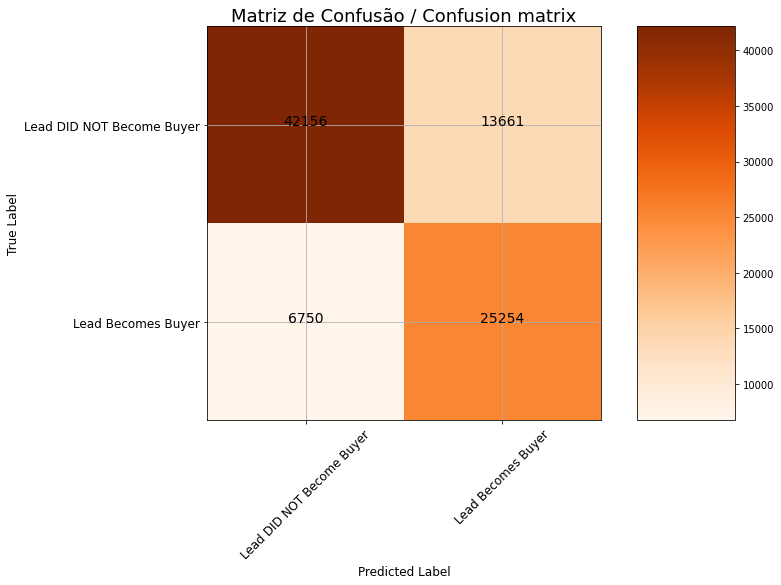

In [124]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges):

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (12, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 18)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 12)
    plt.yticks(tick_marks, classes, size = 12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 14,
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True Label', size = 12)
    plt.xlabel('Predicted Label', size = 12)

# Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_test)
plot_confusion_matrix(cm, classes = ['Lead DID NOT Become Buyer', 'Lead Becomes Buyer'], title = 'Matriz de Confusão / Confusion matrix')

In [125]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred_proba_test[:, -1])

scores = pd.DataFrame({'threshold':threshold,
                       'precision': precision[:-1],
                       'recall':recall[:-1]})

scores['f1score'] = 2 * ((scores['precision'] * scores['recall']) / (scores['precision'] + scores['recall']))

In [126]:
scores

,threshold,precision,recall,f1score
0,0.000000,0.364423,1.000000,0.534179
1,0.100000,0.648514,0.800025,0.716346
2,0.111111,0.648538,0.799994,0.716348
3,0.250000,0.648621,0.799994,0.716398
4,0.333333,0.648660,0.799900,0.716384
5,0.400000,0.648724,0.799088,0.716098
6,0.428571,0.648757,0.799088,0.716118
7,0.500000,0.648748,0.799056,0.716100
8,0.600000,0.648953,0.789089,0.712193
9,0.666667,0.648924,0.788933,0.712112


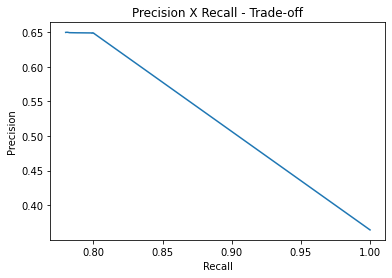

In [127]:
plt.plot(scores['recall'], scores['precision'])
plt.title('Precision X Recall - Trade-off')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Area under ROC curve: 0.78


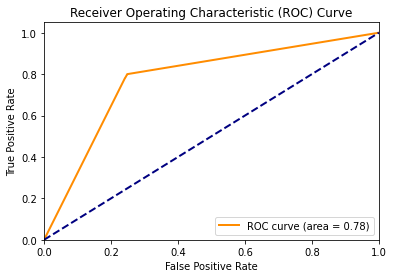

In [128]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test[:, -1], pos_label=True)
print("Area under ROC curve: {:0.2f}".format(auc(fpr, tpr)))

fig, ax = plt.subplots()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()

## Resultado final com métricas de acertividade do algoritmo / *Final result with algorithm accuracy metrics*

**O modelo escolhido apresentou um F1 score de 0,71 para os dados de teste (dados não vistos pelo modelo em seu treino).**

***The chosen model presented an F1 score of 0.71 for the test data (data not seen by the model in its training).***

Análise da matriz de confusão apresentada:
- A matriz de confusão acima mostra que **o modelo identificou 25.254 dos 32.004 leads que se tornaram compradores, que corresponde a 78,9%**.
- A matriz de confusão acima mostra também que **o modelo identificou incorretamente 13.661 dos 55.817 leads que não se tornaram compradores, também chamado de falsos positivos, que corresponde a 24,4%**.

*Analysis of the presented confusion matrix:*

- *The confusion matrix above shows that **the model identified 25,254 of the 32,004 leads that became buyers, which corresponds to 78.9%**.*
- *The confusion matrix above also shows that **the model incorrectly identified 13,661 of the 55,817 leads that did not become buyers, also called false positives, which corresponds to 24.4%**.*

## Fim / *End*